In [1]:
import numpy as np
import pandas as pd
import os
from glob import glob
from pprint import pprint
import json
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import ListedColormap, BoundaryNorm
import matplotlib.pyplot as plt

import cellcycle.PlottingTools as plottingTools
from cellcycle.ParameterSet import ParameterSet
import cellcycle.DataStorage as dataStorage
import cellcycle.DataAnalysis as dataAnalysis
import cellcycle.MakeDataframe as makeDataframe
from cellcycle import mainClass

In [2]:
file_path_input_params_json = '../../input_params.json'
input_param_dict = mainClass.extract_variables_from_input_params_json(file_path_input_params_json)
root_path = input_param_dict["DATA_FOLDER_PATH"]
simulation_location = 'SI/S17_model_validation/datA_variation'
file_path = os.path.join(root_path, simulation_location)
print('file_path', file_path)
parameter_path = os.path.join(file_path, 'parameter_set.csv')
print('parameter_path', parameter_path)

file_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation
parameter_path /home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/parameter_set.csv


In [3]:
pinkish_red = (247 / 255, 109 / 255, 109 / 255)
green = (0 / 255, 133 / 255, 86 / 255)
dark_blue = (36 / 255, 49 / 255, 94 / 255)
light_blue = (168 / 255, 209 / 255, 231 / 255)
blue = (55 / 255, 71 / 255, 133 / 255)
yellow = (247 / 255, 233 / 255, 160 / 255)

In [4]:
v_init_exp = 0.28
std_exp = 0.05

In [5]:
data_frame = makeDataframe.make_dataframe(file_path)
data_frame = makeDataframe.add_average_values_to_df(data_frame)
data_frame = makeDataframe.add_theoretical_init_reg_concentrations_to_df(data_frame)

['/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/vary_datA_position_full_model_low_growth_rate_longer',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/dars2_variation_CV.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/vary_datA_position_full_model_high_longer',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/dars2_variation_rel.pdf',
 '/home/berger/Data/UltrasensitivityCombined/Final_NatCom_Submission/SI/S17_model_validation/datA_variation/dars2_variation_abs.pdf']


# Calculate CV

In [6]:
def return_array_of_initiation_volumes(filepath_h5):
    data_frame = pd.read_hdf(filepath_h5, key='dataset_init_events')
    return data_frame['v_init_per_ori'], data_frame['t_init']

def calculate_CV_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.std(v_init_np[10:])/np.mean(v_init_np[10:])

def calculate_mean_v_init(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.mean(v_init_np[10:])

def extract_v_max(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.amax(v_init_np[10:])

def extract_v_min(row):
    v_init_per_ori, t_init = return_array_of_initiation_volumes(row.path_dataset)
    v_init_np = v_init_per_ori.to_numpy()
    return np.amin(v_init_np[10:])
    
data_frame["CV_v_init"] = data_frame.apply(lambda row: calculate_CV_v_init(row), axis=1)
data_frame["mean_v_init_per_ori"] = data_frame.apply(lambda row: calculate_mean_v_init(row), axis=1)
data_frame["max_v_init_per_ori"] = data_frame.apply(lambda row: extract_v_max(row), axis=1)
data_frame["min_v_init_per_ori"] = data_frame.apply(lambda row: extract_v_min(row), axis=1)
data_frame_high_sorted = data_frame.loc[(data_frame['doubling_rate'] == 2)].sort_values(by=["site_datA"], ascending=True)
data_frame_high_sorted["site_datA"]

11    0.0
21    0.1
20    0.2
14    0.3
18    0.4
12    0.5
13    0.6
19    0.7
15    0.8
16    0.9
17    1.0
Name: site_datA, dtype: float64

# Make Legends

In [7]:
def make_dars2_position_legend(site_dars2):
    return r'$\tau_{{\rm d2}}/T_{{\rm C}}={}$'.format(site_dars2)

def make_doubling_time_legend(doubling_rate):
    return r'$\tau_{{\rm d}}={}$ h'.format(1/doubling_rate)


data_frame.loc[:, 'relative DARS2 position'] = data_frame.apply(lambda row: make_dars2_position_legend(row.site_dars2), axis = 1)
data_frame.loc[:, 'cell-doubling time:'] = data_frame.apply(lambda row: make_doubling_time_legend(row.doubling_rate), axis = 1)


In [8]:
WT_datA_pos_low = data_frame.loc[((data_frame['site_datA'] == 0.1) & (data_frame['doubling_rate'] == 0.5))]["mean_v_init_per_ori"].iloc[0]
WT_datA_pos_high = data_frame.loc[((data_frame['site_datA'] == 0.1) & (data_frame['doubling_rate'] == 2))]["mean_v_init_per_ori"].iloc[0]
print(WT_datA_pos_low, WT_datA_pos_high)
WT_datA_pos_high = 0.3229753868317434
def calculate_normalized_v_init_WT(row, WT_datA_pos_low, WT_datA_pos_high):
    if row.doubling_rate == 0.5:
        return row.mean_v_init_per_ori / WT_datA_pos_low
    else:
        return row.mean_v_init_per_ori / WT_datA_pos_high
    
    
data_frame.loc[:, 'v_init_per_ori_normalized_WT'] = data_frame.apply(lambda row: calculate_normalized_v_init_WT(row, WT_datA_pos_low, WT_datA_pos_high), axis = 1)


0.26964570399004084 0.3230284181339153


# Plot initiation volume per origin

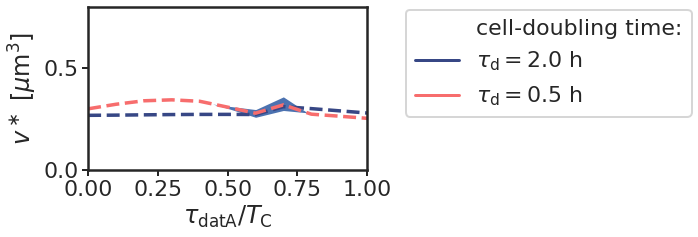

In [9]:
sns.set(style="ticks")
sns.set_context("poster")

data_frame_sorted_1 = data_frame.sort_values(by=["basal_rate_initiator"], ascending=True)
data_frame_sorted_2 = data_frame_sorted_1.sort_values(by=["period_blocked"], ascending=True)

fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='site_datA', 
    y='mean_v_init_per_ori',
    data= data_frame_sorted_2.sort_values(by=["period_blocked"], ascending=True),
#     hue='blocked period:',
    hue='cell-doubling time:',
#     style= 'blocked period:',
    palette= [blue, pinkish_red],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
# ax.lines[2].set_linestyle("--")
# ax.lines[3].set_linestyle("--")
ax.margins(0)

# Variation
ax.fill_between(np.array(data_frame_high_sorted["site_datA"]),
    np.array(data_frame_high_sorted["max_v_init_per_ori"]), 
               np.array(data_frame_high_sorted["min_v_init_per_ori"]))

ax.set(xlabel=r'$\tau_{\rm datA}/T_{\rm C}$', ylabel=r'$v^\ast$ [$\mu$m$^3$]')
ax.set(ylim=(0,0.8))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(file_path + '/dars2_variation_abs.pdf', format='pdf', bbox_inches='tight')

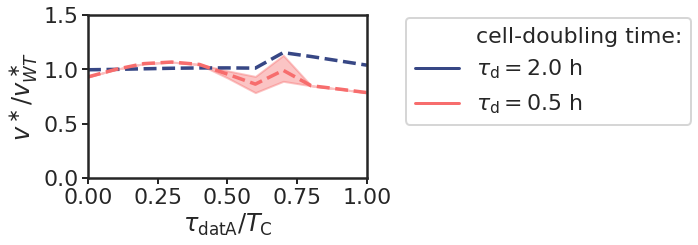

In [10]:
sns.set(style="ticks")
sns.set_context("poster")

fig, ax = plt.subplots(figsize=(5,3))
sns.lineplot(
    x='site_datA', 
    y='v_init_per_ori_normalized_WT',
    data= data_frame.sort_values(by=["site_datA"], ascending=True),
    hue='cell-doubling time:',
    palette= [blue, pinkish_red],
    linewidth = 3.5,
    ax=ax
);
ax.lines[0].set_linestyle("--")
ax.lines[1].set_linestyle("--")
ax.margins(0)

# Variation
ax.fill_between(np.array(data_frame_high_sorted["site_datA"]),
    np.array(data_frame_high_sorted["max_v_init_per_ori"])/WT_datA_pos_high, 
               np.array(data_frame_high_sorted["min_v_init_per_ori"])/WT_datA_pos_high,
               color=pinkish_red, alpha=0.4)

ax.set(xlabel=r'$\tau_{\rm datA}/T_{\rm C}$', ylabel=r'$v^\ast/v^\ast_{WT}$')
ax.set(ylim=(0,1.5))
ax.tick_params(direction='out', length=6, width=2, grid_alpha=0.5)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[1:], labels=labels[1:])
ax.legend(bbox_to_anchor=(1.1, 1.05))
plt.savefig(file_path + '/dars2_variation_rel.pdf', format='pdf', bbox_inches='tight')